# Pancreas endocrinogenesis E1415 - scVelo

### Imports and Settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv
import cellrank as cr
import anndata as ad
from cellrank.kernels import ConnectivityKernel, VelocityKernel
from cellrank.estimators import GPCCA
from tueplots import bundles
from tueplots import axes

In [3]:
plt.rcParams.update(**bundles.neurips2022(usetex=False, nrows=2), **axes.lines(base_width=0.5), **{"figure.dpi": 250})

scv.set_figure_params('scvelo', fontsize=20, color_map='viridis', dpi=400)  # for beautified visualization

cr.logging.print_versions()

cellrank==1.5.1+g16069e2 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.1 numba==0.53.1 scipy==1.9.0 pandas==1.3.5 pygpcca==1.0.3 scikit-learn==1.1.2 statsmodels==0.13.2 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.5.2 seaborn==0.11.2


## Data Loading and Preprocessing

In [4]:
adata = sc.read("../neural_ot/data/pancreas/1415_growth_rate.h5ad")

adata.obsp = {}
adata.uns = {}
adata.obsm = {}
adata.varm = {}
adata.obs = adata.obs.loc[:, ['day', 'celltype']]
adata.var = adata.var[[]]

adata

AnnData object with n_obs × n_vars = 20519 × 16206
    obs: 'day', 'celltype'
    layers: 'spliced', 'unspliced'

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

Filtered out 6334 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.


In [6]:
adata_fourteen = adata[adata.obs['day'] == '14.5', :].copy()
adata_fiveteen = adata[adata.obs['day'] == '15.5', :].copy()

In [7]:
scv.pp.pca(adata_fourteen, n_comps=50)
scv.pp.pca(adata_fiveteen, n_comps=50)
scv.pp.moments(adata_fourteen)
scv.pp.moments(adata_fiveteen)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    finished (0:00:28) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [8]:
sc.tl.umap(adata_fourteen)
sc.tl.umap(adata_fiveteen)

computing UMAP
    finished (0:00:29)
computing UMAP
    finished (0:00:13)


## RNA Velocity Estimation

In [9]:
scv.tl.recover_dynamics(adata_fourteen, n_jobs=10)
scv.tl.velocity(adata_fourteen, mode='dynamical')

recovering dynamics (using 10/112 cores)


  0%|          | 0/1426 [00:00<?, ?gene/s]

/home/icb/luca.eyring/miniconda3/envs/neural-ot/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/icb/luca.eyring/miniconda3/envs/neural-ot/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:08:44) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:13) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [10]:
scv.tl.recover_dynamics(adata_fiveteen, n_jobs=10)
scv.tl.velocity(adata_fiveteen, mode='dynamical')

recovering dynamics (using 10/112 cores)


  0%|          | 0/1385 [00:00<?, ?gene/s]

/home/icb/luca.eyring/miniconda3/envs/neural-ot/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/icb/luca.eyring/miniconda3/envs/neural-ot/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:08:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:14) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Concatenate timepoints 14 and 15

In [11]:
adata = ad.concat([adata_fourteen, adata_fiveteen])
print(adata)

AnnData object with n_obs × n_vars = 20519 × 2000
    obs: 'day', 'celltype', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'


In [12]:
old_adata = sc.read("../neural_ot/data/pancreas/1415_growth_rate.h5ad")
print(old_adata)

AnnData object with n_obs × n_vars = 20519 × 16206
    obs: 'day', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'proliferation', 'G2M_score', 'S_score', 'clusters_fig3_final', 'clusters_fig3_final_noep', 'clusters_fig4_final', 'clusters_fig2_final', 'clusters_fig6_broad_final', 'clusters_fig6_fine_final', 'clusters_fig6_alpha_final', 'celltype'
    var: 'n_cells', 'highly_variable_genes', 'expression_mean', 'dispersion', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_fig6_fine_final_colors', 'day_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'


In [13]:
adata.obsm["X_pca"] = old_adata.obsm["X_pca"].copy()
adata.obsm["X_umap"] = old_adata.obsm["X_umap"].copy()
adata.obs["clusters"] = old_adata.obs["celltype"].copy()
adata.uns["neighbors"] = old_adata.uns["neighbors"].copy()
adata.obsp["connectivities"] = old_adata.obsp["connectivities"].copy()
adata.obsp["distances"] = old_adata.obsp["distances"].copy()

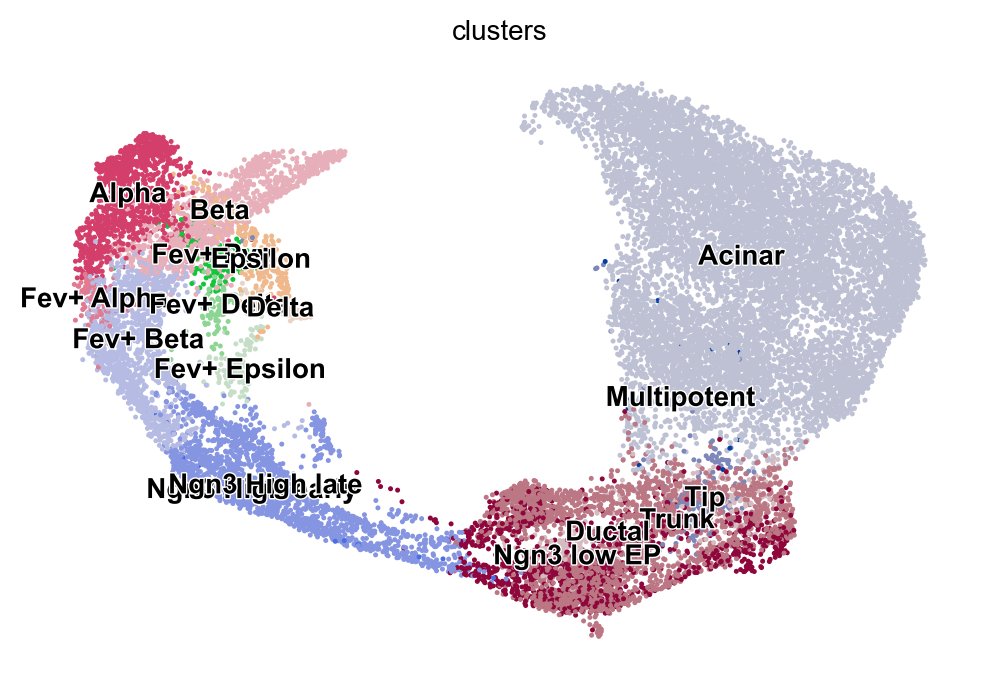

In [14]:
scv.set_figure_params('scvelo', transparent=True, fontsize=10, color_map='viridis')
scv.pl.scatter(adata,  color_map='viridis')

## Alternatively load precomputed adata

In [ ]:
new_adata = sc.read("adata_results/pancreas1415_scvelo.h5ad")

# Cellrank

### Transition probabilities

In [15]:
vk = VelocityKernel(adata).compute_transition_matrix()

Computing transition matrix using `'deterministic'` model


  0%|          | 0/20519 [00:00<?, ?cell/s]

Using `softmax_scale=4.7438`


  0%|          | 0/20519 [00:00<?, ?cell/s]

    Finish (0:01:03)


### Macrostate calculation

In [16]:
g = GPCCA(vk)

Computing Schur decomposition
Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000102e+00 6.4974393301777341e-05 8.3157789984495238e-03 4.0856800922079665e-03 -6.4061320839489504e-04 3.7200223092742710e-03 -7.6596958904686782e-03 5.1488428902469324e-04 3.1556369876140300e-02 4.0126154099938346e-02 -7.8679764727371208e-03 -2.3146864367535935e-02 -2.0234560470316045e-02 -3.7095953910344187e-04 -7.0602967982185136e-03 -2.8722327041838847e-02 -4.2994351713814723e-03 2.1517771248780401e-02 -1.2673146620186301e-02 -3.4847195248263159e-03 -9.8907366997146324e-03 
0.0000000000000000e+00 9.9993264328689491e-01 6.7302947015842702e-03 4.6322730689200434e-03 -3.2280410940720861e-03 -8.9804334841670072e-04 -4.2770687210841344e-03 5.3727984290712289e-03 -3.2623142326408394e-02 -4.1290840272966096e-02 -2.7194386748790445e-04 2.0836800192427299e-02 -2.3404855458878274e-02 7.6274254079772390e-03 -9.7110775310441794e-03 -1.7741761647557894e-02 8.3883943452042655e-04 -4.0112903094253029e-03 1.059

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000009e+00 -6.4974393297557938e-05 8.3157789984096876e-03 -4.0856800921878073e-03 -6.4061320838146741e-04 -3.7200223092730888e-03 7.6596958904421066e-03 5.1488428899748757e-04 3.1556369876301699e-02 4.0126154100039502e-02 7.8679764734133090e-03 2.3146864366802630e-02 2.0234560471226567e-02 -3.7095954008780664e-04 -7.0602967977104582e-03 2.8722327040464075e-02 -4.2994351803364497e-03 -2.1517771248771873e-02 -1.2673146620296470e-02 -3.4847195260673436e-03 -9.8907366988102031e-03 
0.0000000000000000e+00 9.9993264328688891e-01 -6.7302947016314816e-03 4.6322730689452437e-03 3.2280410940654226e-03 -8.9804334839737568e-04 -4.2770687211309572e-03 -5.3727984290760887e-03 3.2623142326237919e-02 4.1290840272763786e-02 -2.7194386686763721e-04 2.0836800193288322e-02 -2.3404855458090207e-02 -7.6274254068872177e-03 9.7110775316454189e-03 -1.7741761648166435e-02 -8.3883942845187269e-04 -4.0112903094126637e-03 -1.0598948927714047e-02 6.9964935621

When computing macrostates, choose a number of states NOT in `[13, 20]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:12)


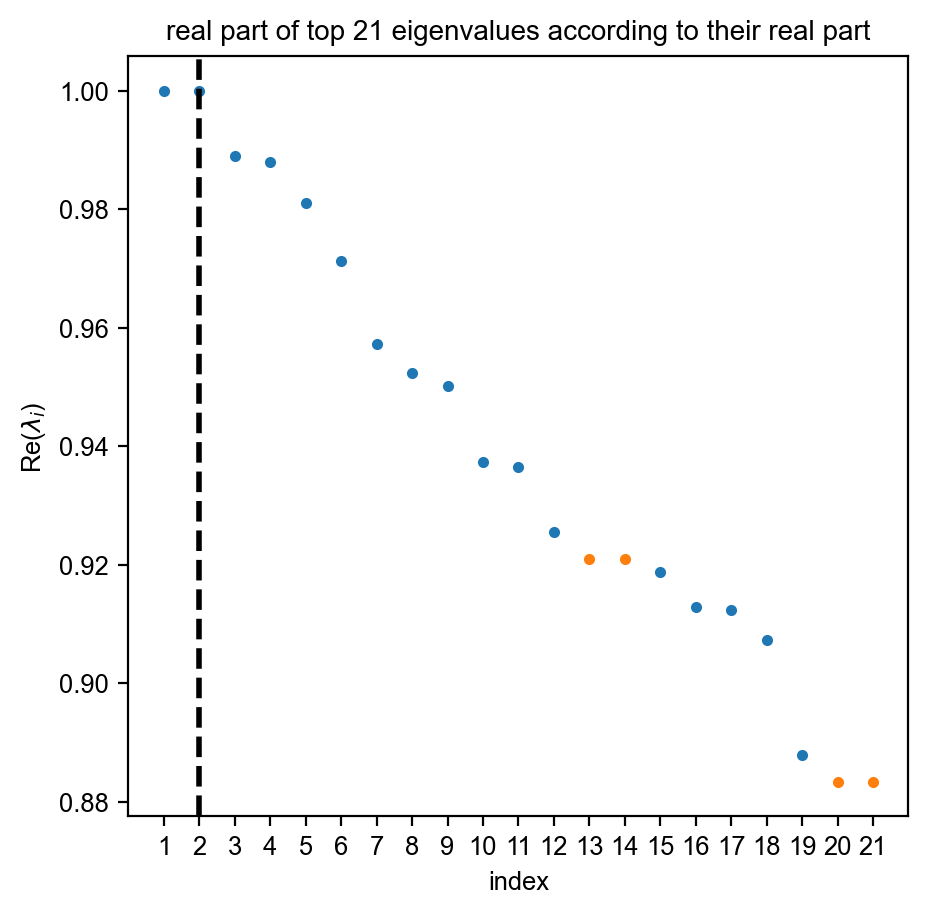

In [17]:
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

Computing `8` macrostates
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:19)


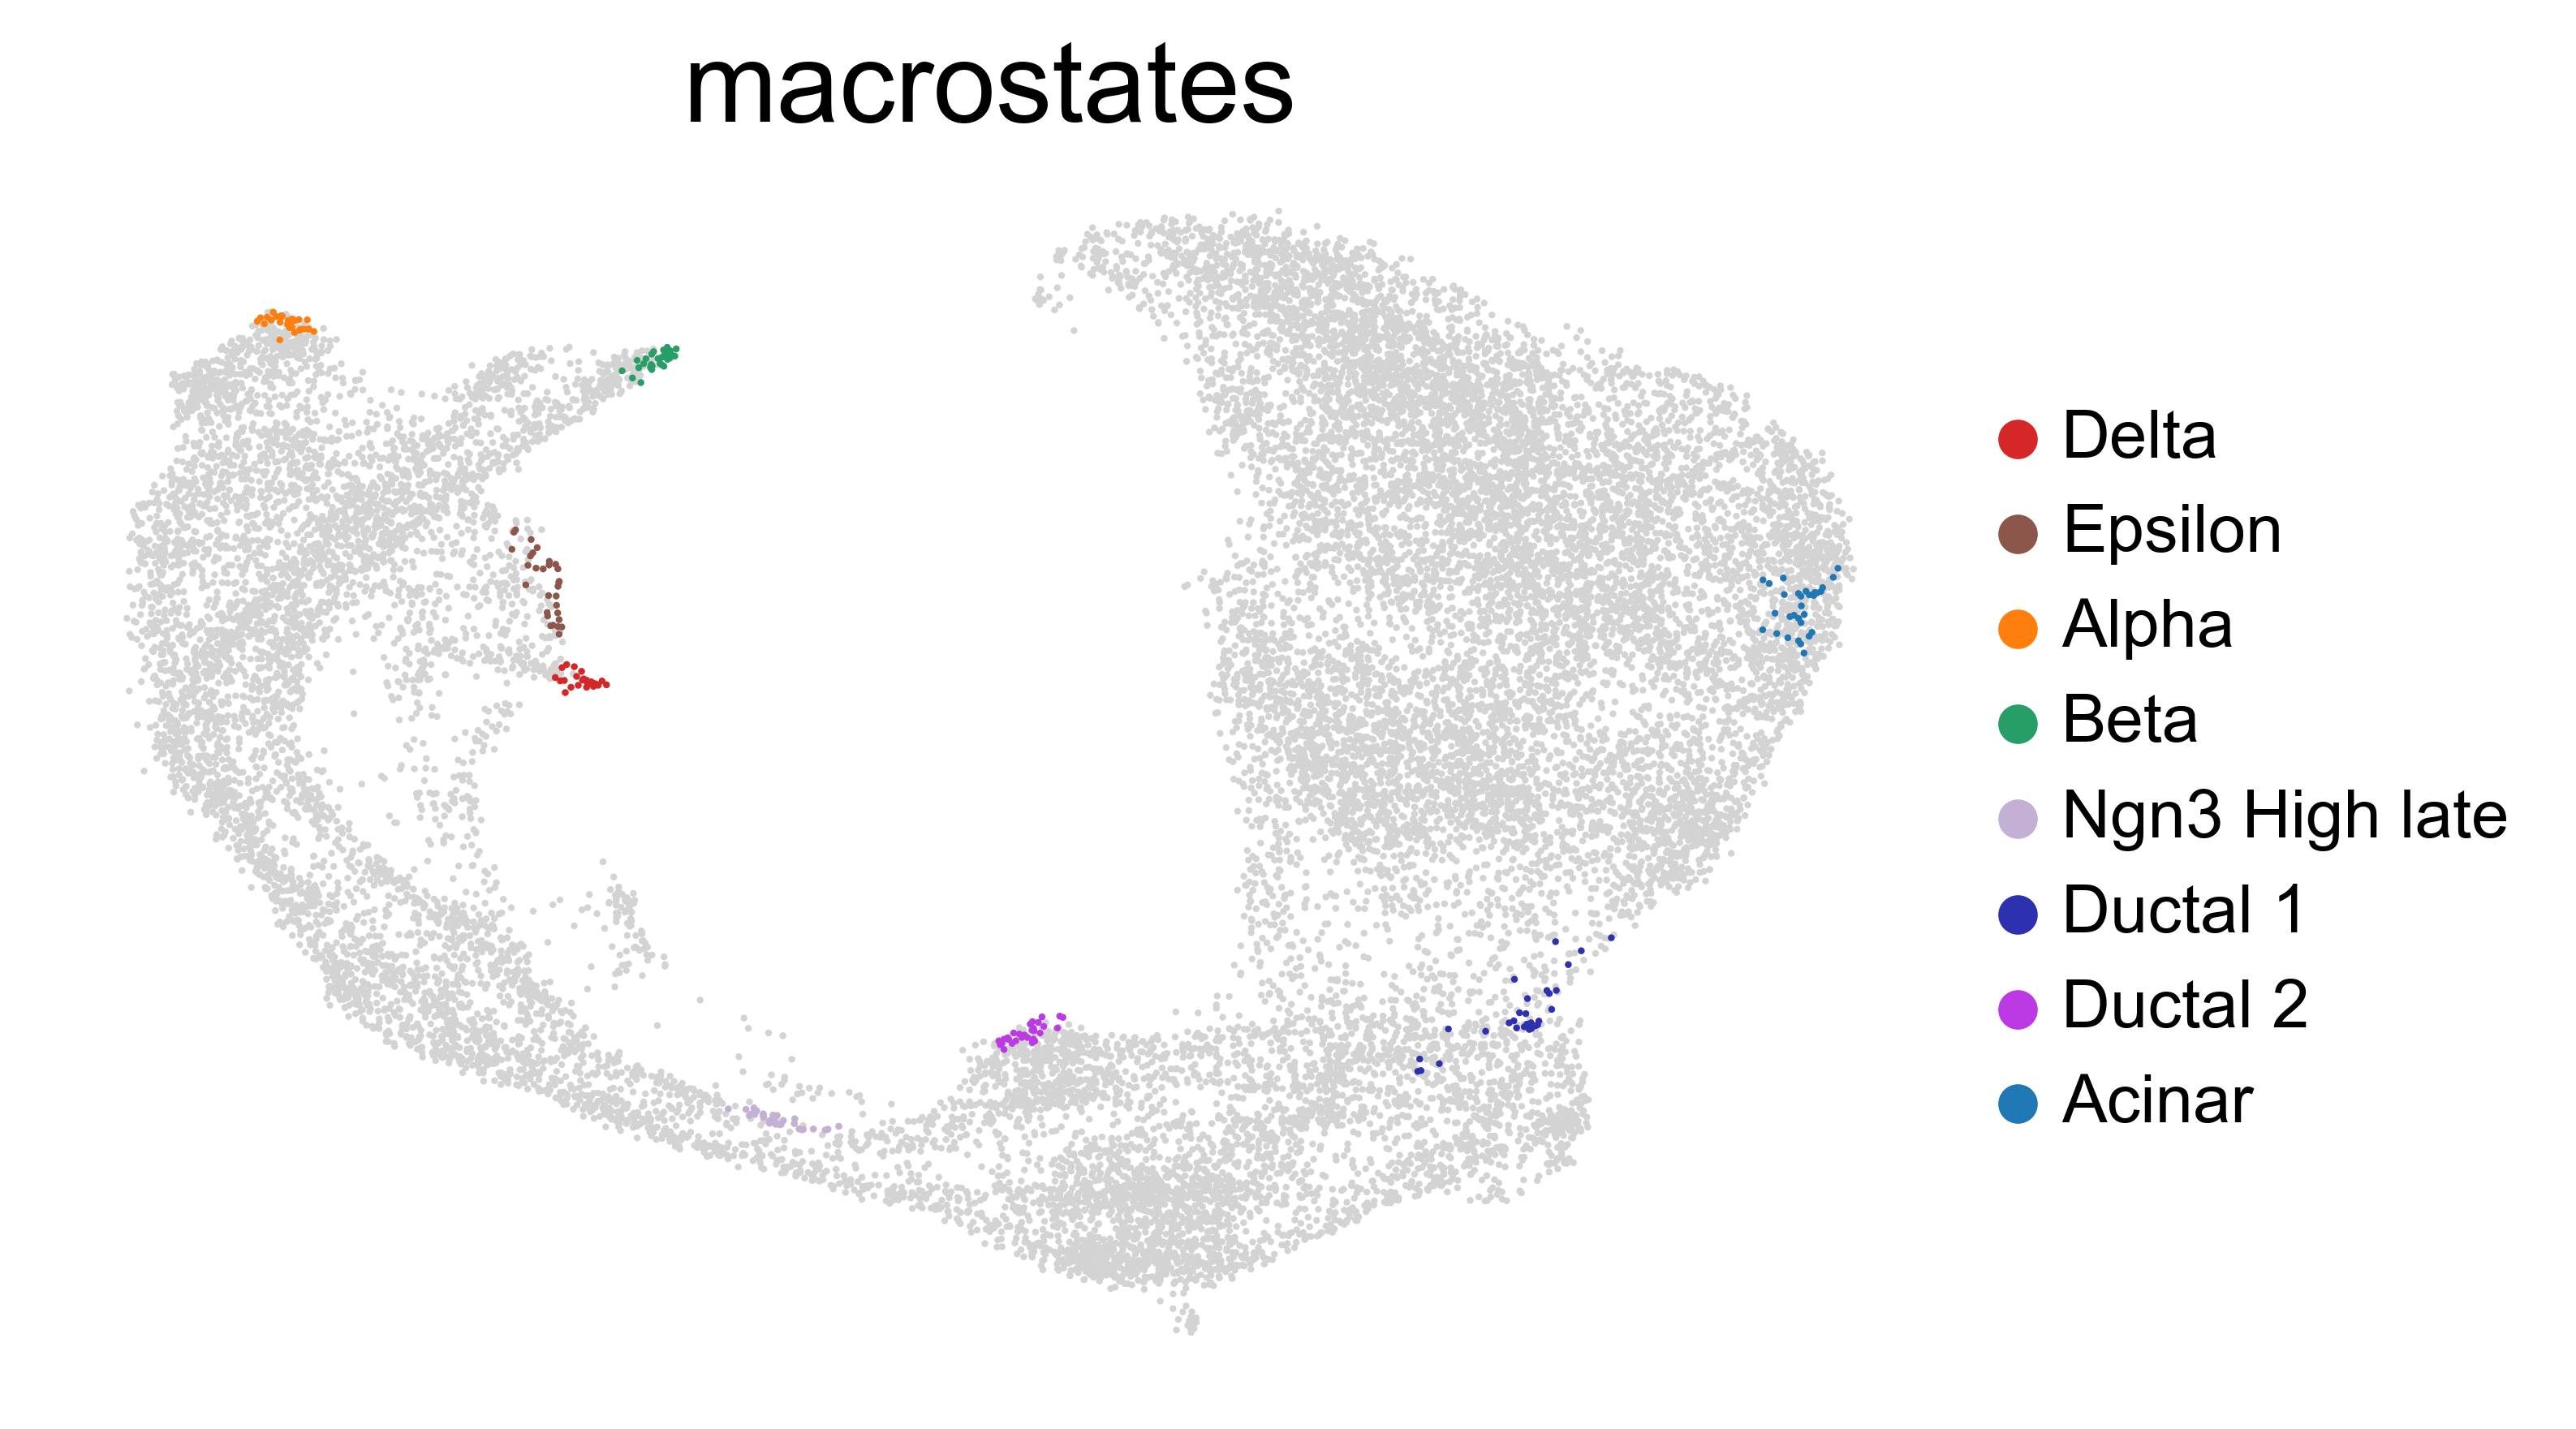

In [27]:
g.compute_macrostates(n_states=8, cluster_key="celltype")
scv.set_figure_params('scvel o', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

### Fate probabilities

DEBUG: Raising an exception if there are less than `6` cells.
Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing absorption probabilities
DEBUG: Solving the linear system using `PETSc` solver `'gmres'` on `1` core(s) with ilu preconditioner and `tol=1e-12`


  0%|          | 0/7 [00:00<?, ?/s]

DEBUG: Calculating mean time to absorption to any absorbing state
DEBUG: Solving the linear system using `PETSc` solver `'gmres'` on `1` core(s) with ilu preconditioner and `tol=1e-12`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/1 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `adata.obsm['absorption_times_fwd']`
       `.absorption_probabilities`
       `.absorption_times`
    Finish (0:00:04)


[0]PETSC ERROR: 

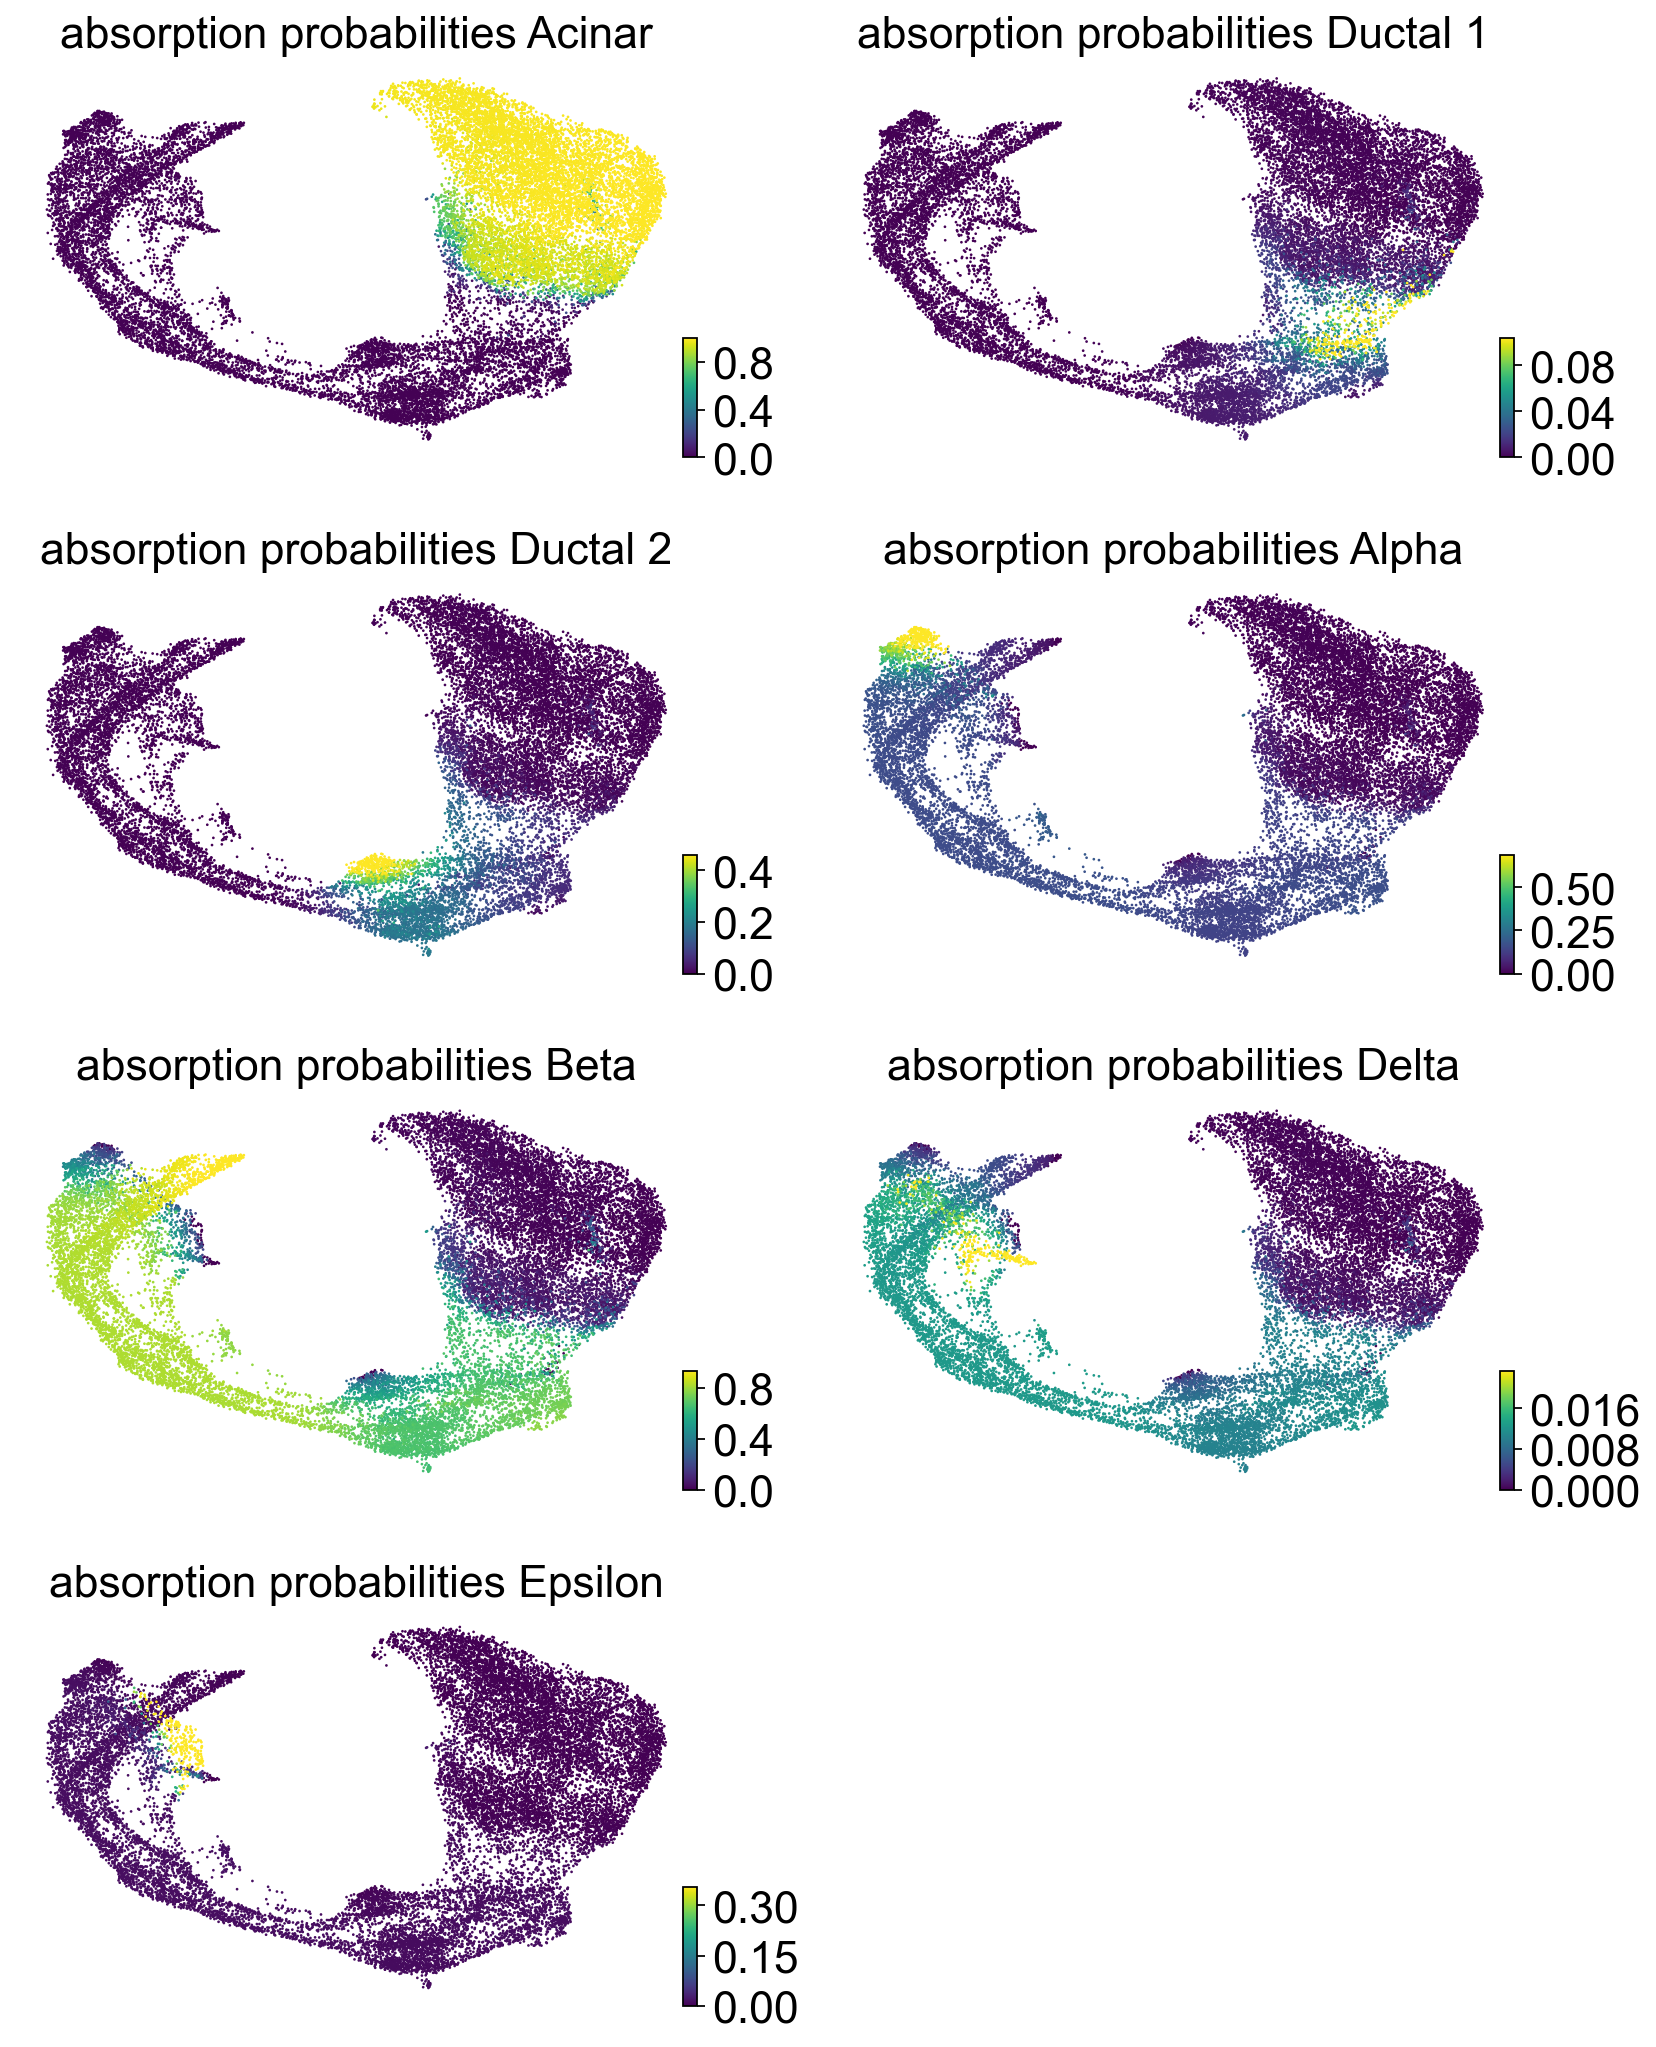

In [28]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar", "Ductal_1", "Ductal_2", "Alpha", "Beta", "Delta", "Epsilon", 
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu', time_to_absorption='all')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

DEBUG: Plotting in mode `'heatmap'`
DEBUG: Saving figure to `'figures/transprobs_pancreas1415_scvelo.png'`


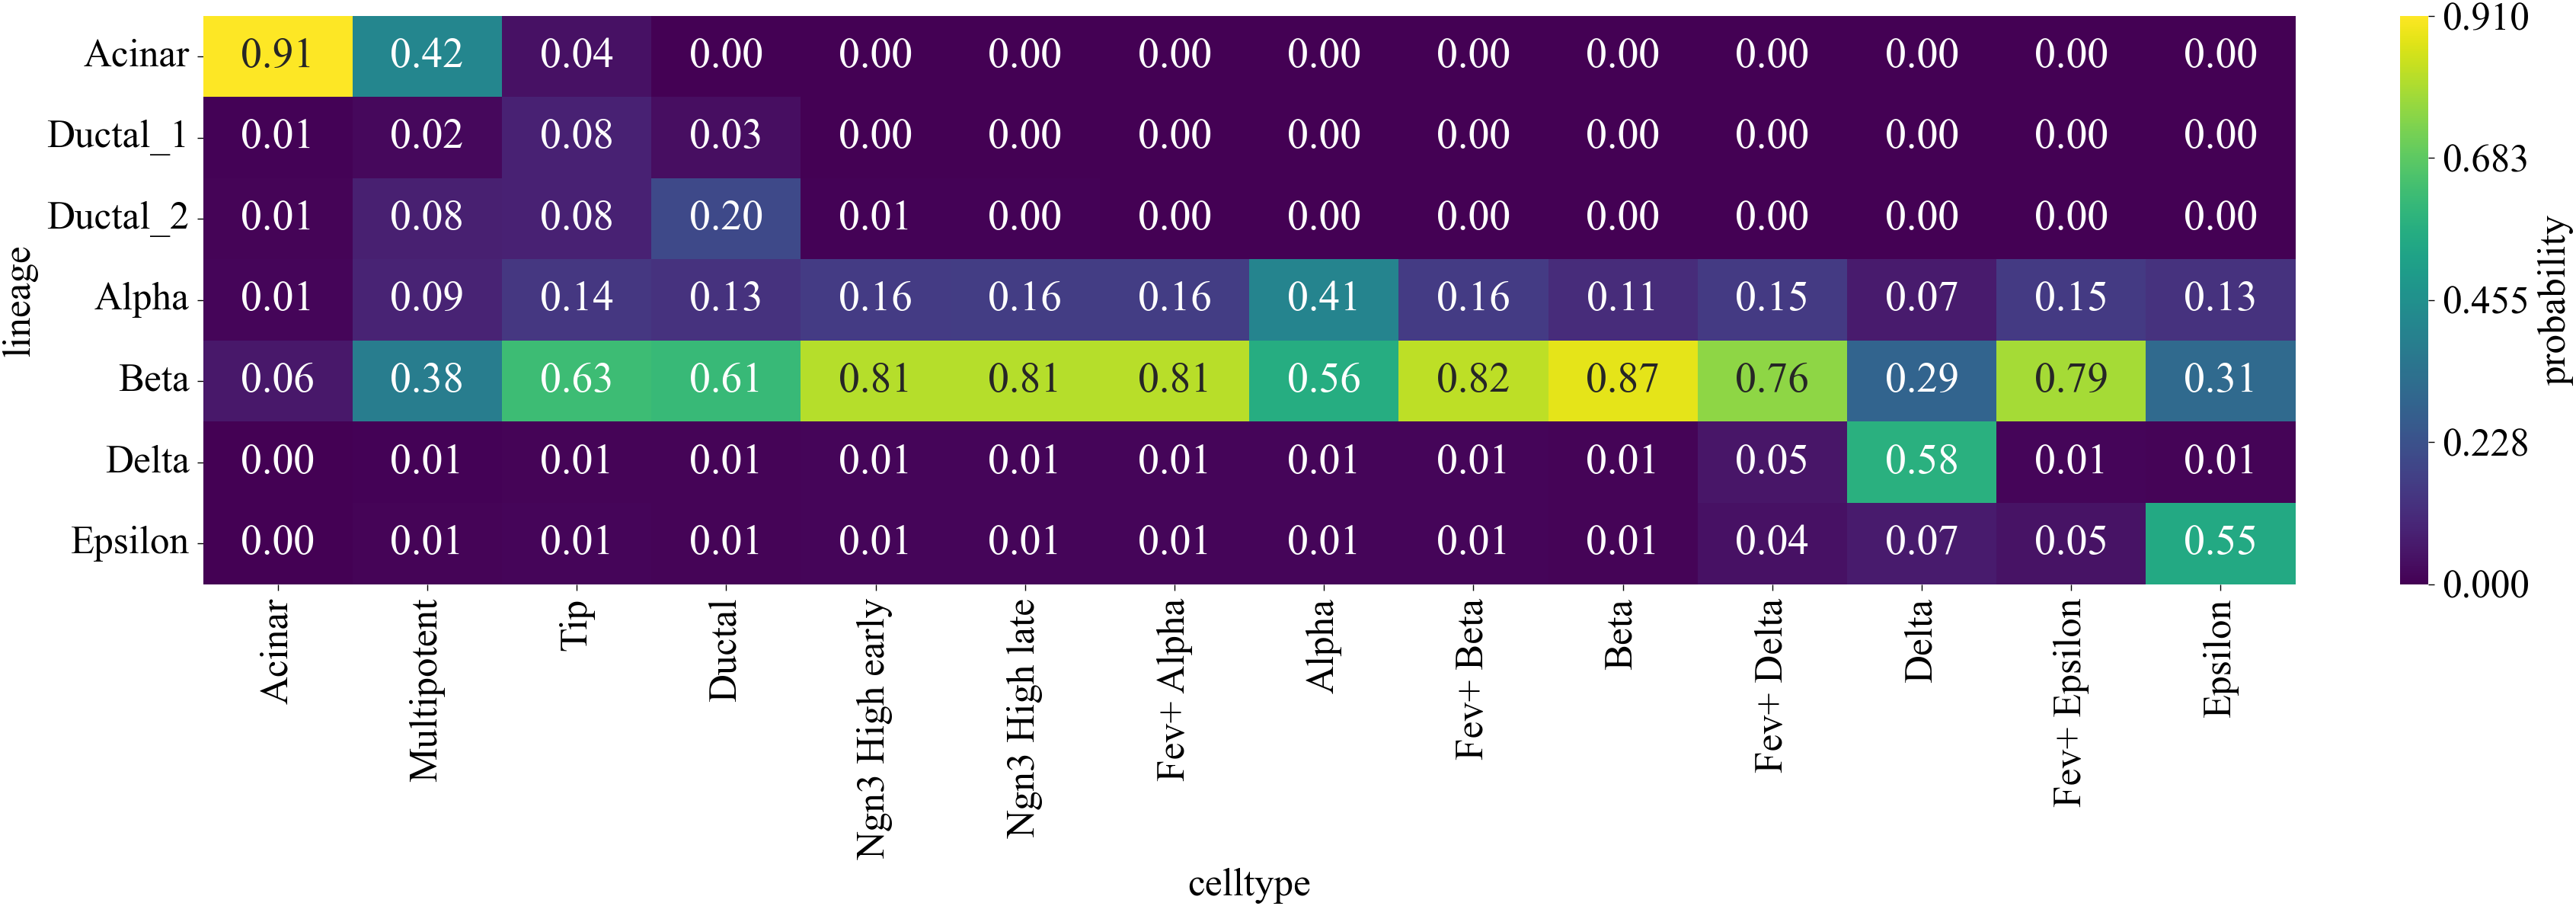

In [107]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar", "Ductal_1", "Ductal_2", "Alpha", "Beta", "Delta", "Epsilon", ],
    cluster_key='celltype',
    clusters=['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 6),
    title="",
    save="transprobs_pancreas1415_scvelo.png"
)

### Velocity Stream Plot

/tmp/ipykernel_100715/2017496064.py:9: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("velstream_pancreas1415_scvelo", dpi=800, bbox_inches='tight')
/tmp/ipykernel_100715/2017496064.py:9: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("velstream_pancreas1415_scvelo", dpi=800, bbox_inches='tight')
/tmp/ipykernel_100715/2017496064.py:9: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("velstream_pancreas1415_scvelo", dpi=800, bbox_inches='tight')
/tmp/ipykernel_100715/2017496064.py:9: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("velstream_pancreas1415_scvelo", dpi=800, bbox_inch

<Figure size 600x400 with 0 Axes>

/home/icb/luca.eyring/miniconda3/envs/neural-ot/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/home/icb/luca.eyring/miniconda3/envs/neural-ot/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


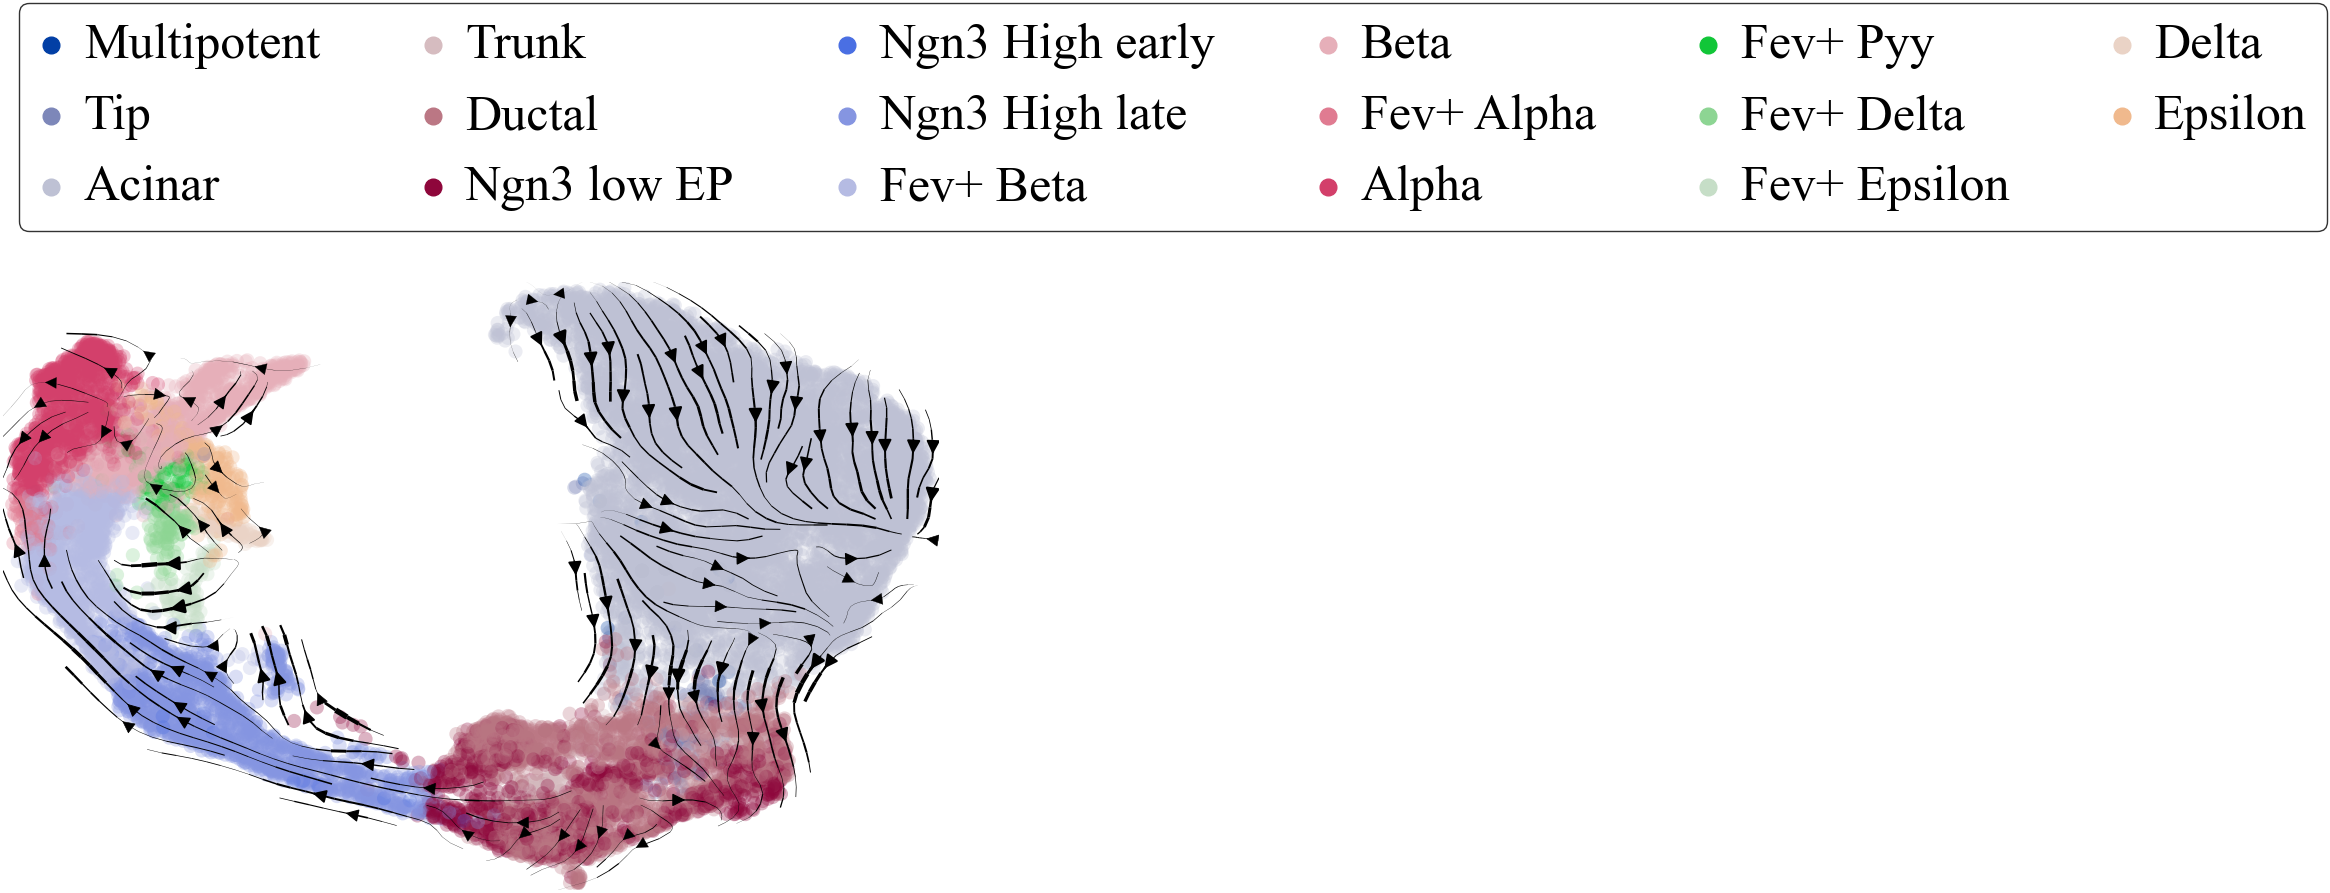

In [101]:
adata.uns["velocity_graph"] = vk.transition_matrix

scv.set_figure_params('scvelo', transparent=True, fontsize=10, dpi_save=400,color_map='viridis')
fig = plt.figure()
ax = scv.pl.velocity_embedding_stream(adata, basis="umap", smooth=0.5, title="", legend_loc="none", show=False)
legend =ax.legend(bbox_to_anchor=[1.25, 1.5], loc='upper center', ncol=6,frameon=True, prop={'size': 18})
#plt.savefig("velstream_pancreas1415_scvelo", dpi=800, bbox_inches='tight')

In [110]:
scv.tl.velocity_confidence(adata)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


saving figure to file ./figures/scvelo_velconf_pancreas1415_scvelo.png


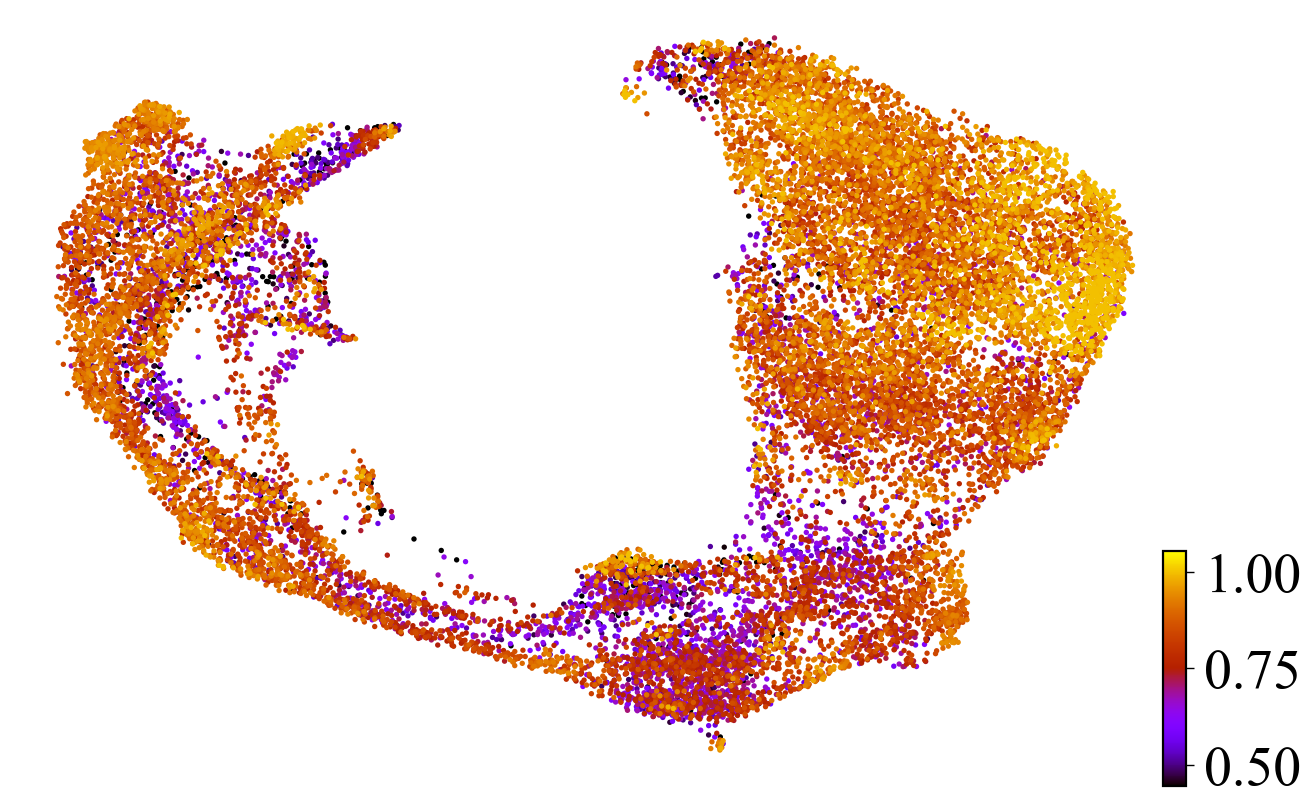

In [114]:
scv.set_figure_params('scvelo', fontsize=20)
scv.settings.presenter_view = False
scv.pl.scatter(adata, color='velocity_confidence',
               perc=[2, 98],
               cmap='gnuplot',
               vmid=0.75,
               rescale_color=[0.5, 1.0],
               size=15,
               title="",
               #save="velconf_pancreas1415_scvelo.png")

In [117]:
adata.write("adata_results/pancreas1415_scvelo.h5ad")